1. torchvision을 사용하여 CIFAR10의 학습용 데이터, 시험용 데이터 불러오기, 정규화
2. 합성곱 신경망 정의
3. 손실 함수 정의
4. 학습용 데이터를 사용하여 신경망 학습
5. 시험용 데이터를 사용하여 신경망 검사

In [1]:
#결과 inline에 출력
%matplotlib inline

In [2]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import collections
from sklearn import datasets
from imblearn import under_sampling
from typing import Any, Callable, Dict, List, Optional, Tuple
import os
import numpy as np
from torch.utils.data import WeightedRandomSampler

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
print(torch.cuda.device_count())

2


In [5]:
print(torch.__version__)

1.7.1+cu101


In [6]:
print(torchvision.__version__)

0.8.2+cu101


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 8 ,pin_memory= True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8, pin_memory= True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
type(trainset.data)

numpy.ndarray

In [9]:
trainset.data.shape

(50000, 32, 32, 3)

In [10]:
trainset.data[0][0]

array([[ 59,  62,  63],
       [ 43,  46,  45],
       [ 50,  48,  43],
       [ 68,  54,  42],
       [ 98,  73,  52],
       [119,  91,  63],
       [139, 107,  75],
       [145, 110,  80],
       [149, 117,  89],
       [149, 120,  93],
       [131, 103,  77],
       [125,  99,  76],
       [142, 115,  91],
       [144, 112,  86],
       [137, 105,  79],
       [129,  97,  71],
       [137, 106,  79],
       [134, 106,  76],
       [124,  97,  64],
       [139, 113,  78],
       [139, 112,  75],
       [133, 105,  69],
       [136, 105,  74],
       [139, 108,  77],
       [152, 120,  89],
       [163, 131, 100],
       [168, 136, 108],
       [159, 129, 102],
       [158, 130, 104],
       [158, 132, 108],
       [152, 125, 102],
       [148, 124, 103]], dtype=uint8)

In [11]:
type(trainset.targets)

list

In [12]:
print('Original dataset shape %s' % collections.Counter(trainset.targets))


Original dataset shape Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


In [13]:
class unbalance_CIFAR10(CIFAR10):
     def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
    ) -> None:
        super(unbalance_CIFAR10, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        

     
        rus = under_sampling.RandomUnderSampler(
            sampling_strategy={
                0: 50,
                1: 5000,
                2: 50,
                3: 5000,
                4: 50,
                5: 5000,
                6: 50,
                7: 5000,
                8: 50,
                9: 5000
                
            },
            random_state=42
        )
        self.data, self.targets = rus.fit_resample(np.array(self.data).reshape(50000,32*32*3), np.array(self.targets))
#         self.data, self.targets = torch.Tensor(self.data.reshape(-1,32,32,3)).to(dtype=torch.uint8), torch.Tensor(self.targets).to(dtype=torch.uint8)
        self.data, self.targets = self.data.reshape(-1,32,32,3), self.targets



In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = unbalance_CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)



testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [15]:
print('reshape dataset shape %s' % collections.Counter(trainset.targets.tolist()))

reshape dataset shape Counter({1: 5000, 3: 5000, 5: 5000, 7: 5000, 9: 5000, 0: 50, 2: 50, 4: 50, 6: 50, 8: 50})


In [16]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [17]:
idx2class = {v: k for k, v in trainset.class_to_idx.items()}
print(idx2class)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [18]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [19]:
print("Distribution of classes: \n", get_class_distribution(trainset))

Distribution of classes: 
 {'airplane': 50, 'automobile': 5000, 'bird': 50, 'cat': 5000, 'deer': 50, 'dog': 5000, 'frog': 50, 'horse': 5000, 'ship': 50, 'truck': 5000}


In [20]:
target_list = torch.tensor(trainset.targets)
print(target_list)

tensor([0, 0, 0,  ..., 9, 9, 9])


In [21]:
target_list = target_list[torch.randperm(len(target_list))]


In [22]:
class_count = [i for i in get_class_distribution(trainset).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([0.0200, 0.0002, 0.0200, 0.0002, 0.0200, 0.0002, 0.0200, 0.0002, 0.0200,
        0.0002])


In [23]:
class_weights_all = [class_weights[int(t)] for t in target_list]
print(class_weights_all)

[tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(

In [24]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [25]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=weighted_sampler,
                                          shuffle=False, num_workers= 8 ,pin_memory= True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, pin_memory= True)


In [26]:
type(trainset.data)

numpy.ndarray

In [27]:
type(testset.data)

numpy.ndarray

In [28]:
trainset.data.shape

(25250, 32, 32, 3)

In [29]:
type(trainset.targets)

numpy.ndarray

In [30]:
len(trainset.data)

25250

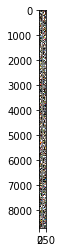

  cat   dog   cat   dog


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [32]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
          nn.Conv2d(3, 32, 3),
          nn.ReLU(),
          nn.Conv2d(32, 32, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )

        self.layer2 = torch.nn.Sequential(
          nn.Conv2d(32, 64, 3),
          nn.ReLU(),
          nn.Conv2d(64, 64, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )


        self.fc1 = nn.Linear(1600, 120)
        self.bn1 = nn.BatchNorm1d(120)
        self.bn2 = nn.BatchNorm1d(84)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()

if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

net.to(device)

DataParallel(
  (module): Net(
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (fc1): Linear(in_features=1600, out_features=120, bias=True)
    (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_feat

In [33]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [34]:
import time
start = time.time()  # 시작 시간 저장

In [35]:
net.train()
for epoch in range(600):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 1.798
[2,    10] loss: 1.123
[3,    10] loss: 0.794
[4,    10] loss: 0.624
[5,    10] loss: 0.519
[6,    10] loss: 0.473
[7,    10] loss: 0.430
[8,    10] loss: 0.404
[9,    10] loss: 0.378
[10,    10] loss: 0.361
[11,    10] loss: 0.327
[12,    10] loss: 0.317
[13,    10] loss: 0.307
[14,    10] loss: 0.275
[15,    10] loss: 0.277
[16,    10] loss: 0.268
[17,    10] loss: 0.256
[18,    10] loss: 0.252
[19,    10] loss: 0.234
[20,    10] loss: 0.245
[21,    10] loss: 0.219
[22,    10] loss: 0.208
[23,    10] loss: 0.207
[24,    10] loss: 0.206
[25,    10] loss: 0.191
[26,    10] loss: 0.184
[27,    10] loss: 0.176
[28,    10] loss: 0.175
[29,    10] loss: 0.167
[30,    10] loss: 0.174
[31,    10] loss: 0.154
[32,    10] loss: 0.151
[33,    10] loss: 0.144
[34,    10] loss: 0.141
[35,    10] loss: 0.137
[36,    10] loss: 0.132
[37,    10] loss: 0.127
[38,    10] loss: 0.128
[39,    10] loss: 0.116
[40,    10] loss: 0.115
[41,    10] loss: 0.113
[42,    10] loss: 0.101
[

[334,    10] loss: 0.011
[335,    10] loss: 0.010
[336,    10] loss: 0.011
[337,    10] loss: 0.013
[338,    10] loss: 0.012
[339,    10] loss: 0.011
[340,    10] loss: 0.010
[341,    10] loss: 0.012
[342,    10] loss: 0.012
[343,    10] loss: 0.012
[344,    10] loss: 0.012
[345,    10] loss: 0.012
[346,    10] loss: 0.011
[347,    10] loss: 0.011
[348,    10] loss: 0.011
[349,    10] loss: 0.010
[350,    10] loss: 0.009
[351,    10] loss: 0.010
[352,    10] loss: 0.012
[353,    10] loss: 0.011
[354,    10] loss: 0.011
[355,    10] loss: 0.010
[356,    10] loss: 0.010
[357,    10] loss: 0.012
[358,    10] loss: 0.010
[359,    10] loss: 0.008
[360,    10] loss: 0.008
[361,    10] loss: 0.008
[362,    10] loss: 0.010
[363,    10] loss: 0.011
[364,    10] loss: 0.013
[365,    10] loss: 0.012
[366,    10] loss: 0.012
[367,    10] loss: 0.011
[368,    10] loss: 0.012
[369,    10] loss: 0.015
[370,    10] loss: 0.014
[371,    10] loss: 0.012
[372,    10] loss: 0.011
[373,    10] loss: 0.010


In [36]:
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 1202.624002456665


In [37]:
# PATH = './fashion_net.pth'
# torch.save(net.state_dict(), PATH)

In [38]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# 이미지를 출력합니다.
# imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

GroundTruth:  horse horse   car  bird  frog  frog  ship plane   dog truck plane  bird  bird truck  bird   car   cat   cat  deer horse truck   cat   cat  deer  frog plane truck  deer   dog horse  ship horse   cat  frog   dog  bird  frog  bird  bird truck  bird  bird  bird horse   cat   car   car  deer horse  frog  ship   car truck  frog plane plane  frog horse   dog horse  ship  ship plane  deer


In [39]:
# net = Net()
# net.to(device)
# net.load_state_dict(torch.load(PATH))

In [40]:
net.train()
outputs = net(images)

In [41]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:  horse horse   car   cat   cat   car horse truck   dog truck   car   dog plane truck horse truck   cat   cat   cat horse truck   dog   cat horse   cat   car truck   cat   dog   dog truck truck   cat   cat   dog   cat   cat horse   cat truck   car   cat   dog horse   cat truck   car horse horse   cat   car truck truck truck   car   car   car truck horse horse truck   car truck   cat truck   cat   dog   cat   cat   cat truck   dog truck   dog   dog truck   cat   car horse truck   cat   dog   car   cat   dog   cat   car truck   cat truck truck   cat   cat truck   cat truck   dog truck   car   car   dog   cat horse horse   car   dog   dog   dog truck   dog truck horse   car truck horse   dog   cat   car   car horse   cat   dog   car   cat truck   cat   dog   cat   dog truck horse   dog horse truck truck   dog  bird  deer   cat   car horse truck   dog   car   car   car truck horse truck   dog   car   car truck   car   cat truck   dog   car horse   car  frog   car horse truck truc

In [42]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 45 %


In [43]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 12.2 %
Accuracy for class car   is: 89.9 %
Accuracy for class bird  is: 4.9 %
Accuracy for class cat   is: 76.0 %
Accuracy for class deer  is: 4.1 %
Accuracy for class dog   is: 73.3 %
Accuracy for class frog  is: 7.0 %
Accuracy for class horse is: 87.0 %
Accuracy for class ship  is: 6.3 %
Accuracy for class truck is: 92.6 %


In [44]:
for i in range(10):
    print(classes[labels[i]])

bird
horse
ship
horse
truck
ship
dog
cat
car
frog
